In [1]:
# Imports.
import naclib.stpol
import naclib.util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Input for fitting; spots in df_locs0 are shifted towards spots in df_locs1, the latter remain static.
df_locs0_fit = pd.read_csv('../example/reference_locs_green.csv')
df_locs1_fit = pd.read_csv('../example/reference_locs_red.csv')
fig_size = [512, 256]  # Original image size, needed for rescaling to unit circle.
threshold = 5  # Nearest neighbour search threshold in pixels.

# Input for running correction.
df_locs0_predict = pd.read_csv('../example/nanoruler_data_c1.csv')
df_locs1_predict = pd.read_csv('../example/nanoruler_data_c2.csv')
pixel_size = 125  # in nm/px

In [3]:
# Find spot pairs, by finding nearest neighbours between locs0 and locs1.
locs0_raw = np.zeros((len(df_locs0_fit), 2))
locs0_raw[:, 0] = df_locs0_fit['x']
locs0_raw[:, 1] = df_locs0_fit['y']
locs1_raw = np.zeros((len(df_locs1_fit), 2))
locs1_raw[:, 0] = df_locs1_fit['x']
locs1_raw[:, 1] = df_locs1_fit['y']

# Find the nearest neighbours; rescale to unit circle.
mapping = naclib.util.find_neighbours(locs0_raw, locs1_raw, threshold=threshold)
locs0_pairs, locs1_pairs = naclib.util.make_pairs(locs0_raw, locs1_raw, mapping)
locs0, scale = naclib.util.loc_to_unitcircle(locs0_pairs, fig_size)
locs1, scale = naclib.util.loc_to_unitcircle(locs1_pairs, fig_size)

# Get distortion grid.
D = np.zeros(locs0.shape)
D[:, 0] = locs1[:, 0] - locs0[:, 0]
D[:, 1] = locs1[:, 1] - locs0[:, 1]

In [4]:
# Get ST polynomial decomposition coefficients.
model = naclib.DistortionCorrection()
model.fit(locs0, D)

In [11]:
# Rescale data to fit to unit circle.
locs_raw = np.zeros((len(df_locs1_predict), 2))
locs_raw[:, 0] = df_locs1_predict['x [nm]'] / pixel_size
locs_raw[:, 1] = df_locs1_predict['y [nm]'] / pixel_size
locs, scale = naclib.util.loc_to_unitcircle(locs_raw, fig_size)

# Get correction field.
P = model.predict(locs)

# Apply correction.
locs_corrected = locs + P
locs_corrected = pixel_size * naclib.util.unitcircle_to_loc(locs_corrected, fig_size)

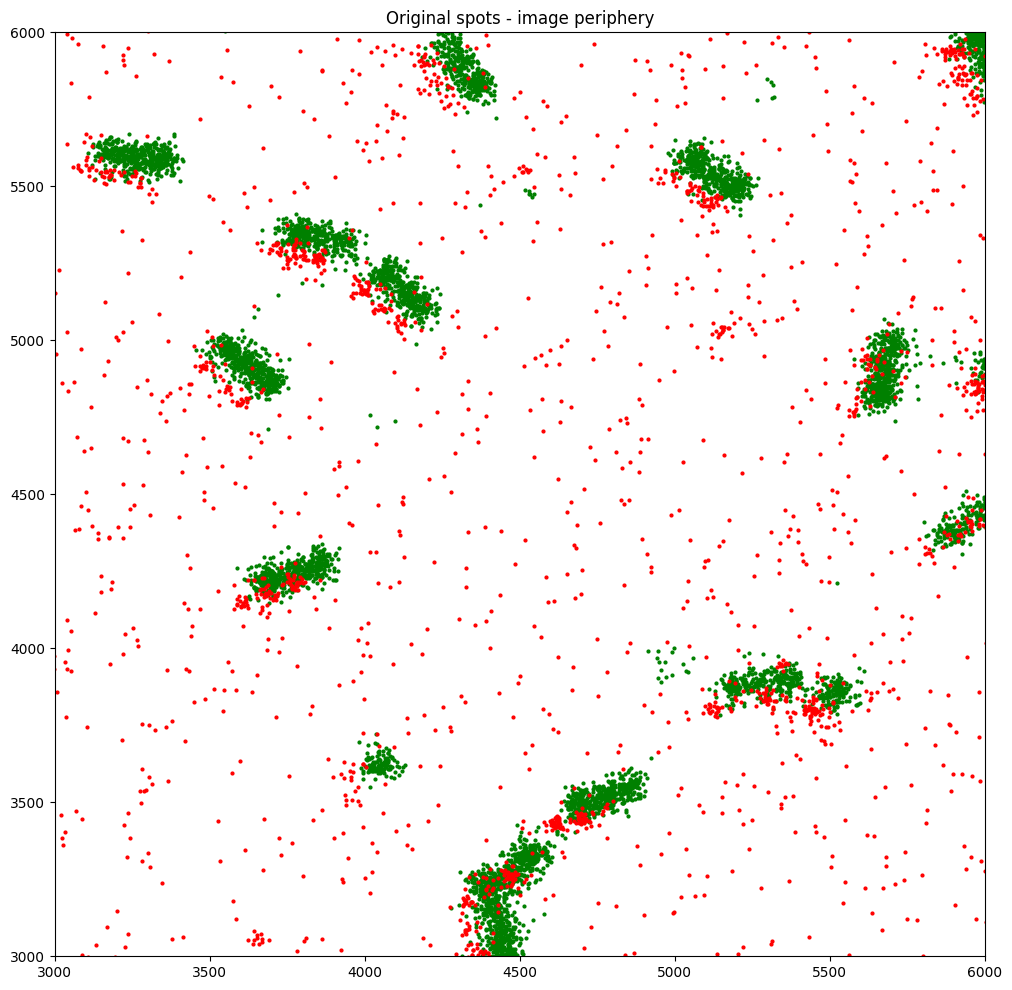

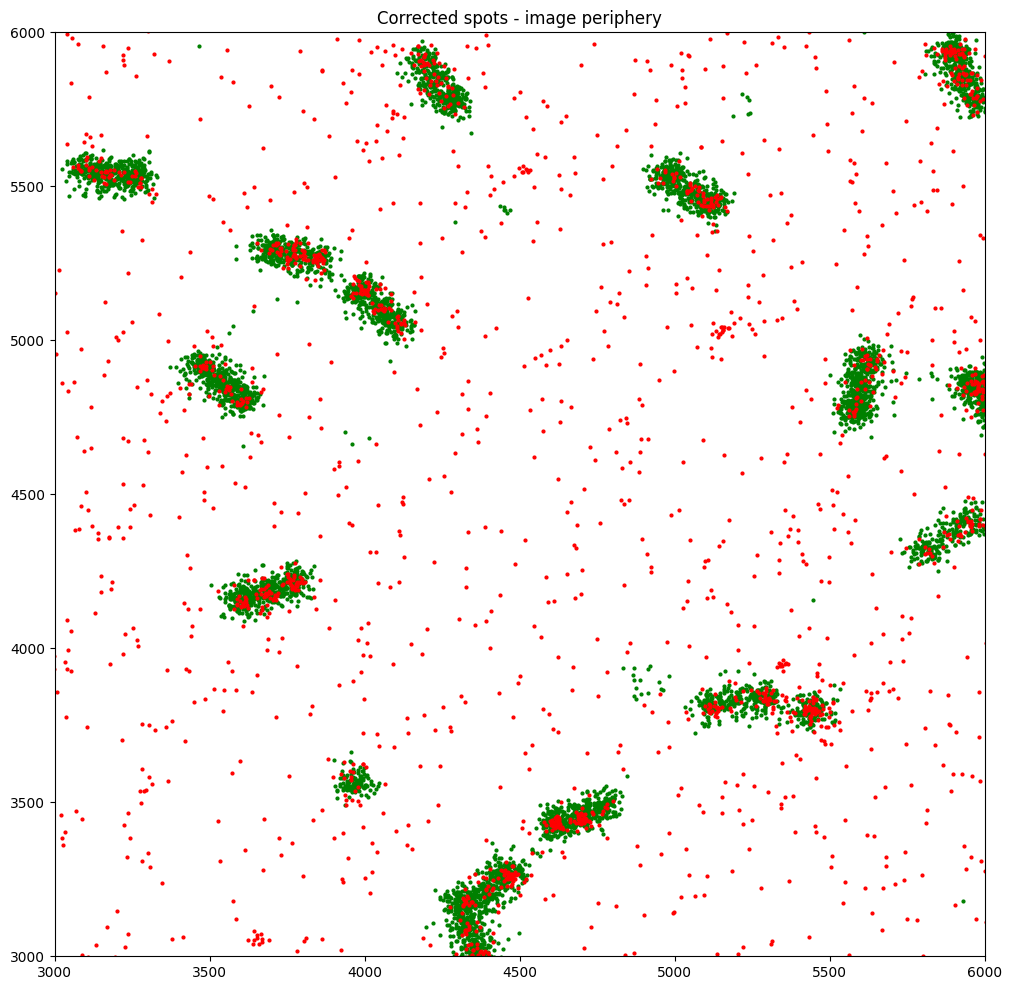

In [12]:
# Plot original
plt.figure(figsize=(12, 12))
plt.title('Original spots - image periphery')
plt.scatter(df_locs1_predict['x [nm]'], df_locs1_predict['y [nm]'], c='g', s=4)
plt.scatter(df_locs0_predict['x [nm]'], df_locs0_predict['y [nm]'], c='r', s=4)
plt.xlim((3000, 6000))
plt.ylim((3000, 6000))
plt.show()
plt.close()

# Plot result
plt.figure(figsize=(12, 12))
plt.title('Corrected spots - image periphery')
plt.scatter(locs_corrected[:, 0], locs_corrected[:, 1], c='g', s=4)
plt.scatter(df_locs0_predict['x [nm]'], df_locs0_predict['y [nm]'], c='r', s=4)
plt.xlim((3000, 6000))
plt.ylim((3000, 6000))
plt.show()
plt.close()